In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import Dataset
import matplotlib.pyplot as plt
from itertools import chain
import gc
import torch
import math

In [2]:
with open("./riscv_dataset.txt") as f:
    texts = f.readlines()

print("Sample line count:", len(texts))
print("Example line:", texts[0])

Sample line count: 18038
Example line: # See LICENSE for license details.



## Data Preprocessing

In [3]:
# Remove empty lines and comments from the dataset
# Keep only lines that are not empty and do not start with #, //, or ;

def clean_lines(lines):
    cleaned = []
    for line in lines:
        line = line.strip()
        if not line or line.startswith(("#", "//", ";", "TEST", "RVTEST")):
            continue
        cleaned.append(line)
    return cleaned

texts = clean_lines(texts)
print("Cleaned line count:", len(texts))
print("Example cleaned line:", texts[0])

Cleaned line count: 3407
Example cleaned line: .data


## Raw Token Frequency (Opcode)

In [4]:
from collections import Counter

# Strip comments and empty lines
clean_lines = [line.split('#')[0].strip() for line in texts if line.strip() and not line.strip().startswith('#')]

# Get opcodes (first token in each line)
opcodes = [line.split()[0] for line in clean_lines if line]

# Count frequency
opcode_counts = Counter(opcodes)

# Show top 10 most frequent opcodes
print(opcode_counts.most_common(10))

[('li', 335), ('.data', 214), ('la', 183), ('.word', 166), ('addi', 148), ('SREG', 96), (')', 92), ('j', 86), ('csrr', 82), ('.align', 80)]


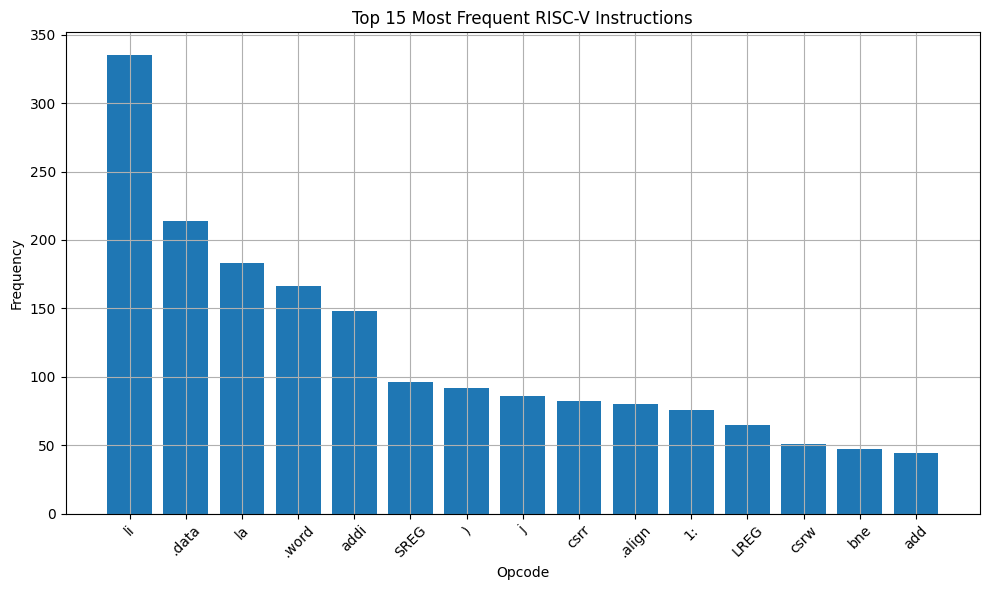

In [5]:
top_ops = opcode_counts.most_common(15)
labels, values = zip(*top_ops)

plt.figure(figsize=(10,6))
plt.bar(labels, values)
plt.title("Top 15 Most Frequent RISC-V Instructions")
plt.xlabel("Opcode")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Tokenize the dataset using a pre-trained tokenizer

In [6]:
tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-multi")
tokenizer.pad_token = tokenizer.eos_token

dataset = Dataset.from_dict({"text": texts})
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=512)

# 80% train, 20% test
dataset_split = dataset.train_test_split(test_size=0.2)

# Tokenize both splits
tokenized_dataset = dataset_split.map(tokenize)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2725 [00:00<?, ? examples/s]

Map:   0%|          | 0/682 [00:00<?, ? examples/s]

In [7]:
# Tokenize and extract input_ids properly
def extract_input_ids(example):
    return {"input_ids": tokenizer(example["text"])["input_ids"]}

# Apply the function to the dataset
tokenized_ids_dataset = dataset.map(extract_input_ids)

# Flatten all token IDs
flat_ids = list(chain.from_iterable(tokenized_ids_dataset["input_ids"]))

# Count frequency
token_counts = Counter(flat_ids)

# Decode top 10 most frequent tokens
top_token_ids = [i for i, _ in token_counts.most_common(10)]
top_tokens = tokenizer.convert_ids_to_tokens(top_token_ids)
print("Top 10 frequent tokens:", top_tokens)

Map:   0%|          | 0/3407 [00:00<?, ? examples/s]

Top 10 frequent tokens: [',', '0', '_', '.', '1', 'x', 'Ġ0', 'Ġa', 'Ġt', '(']


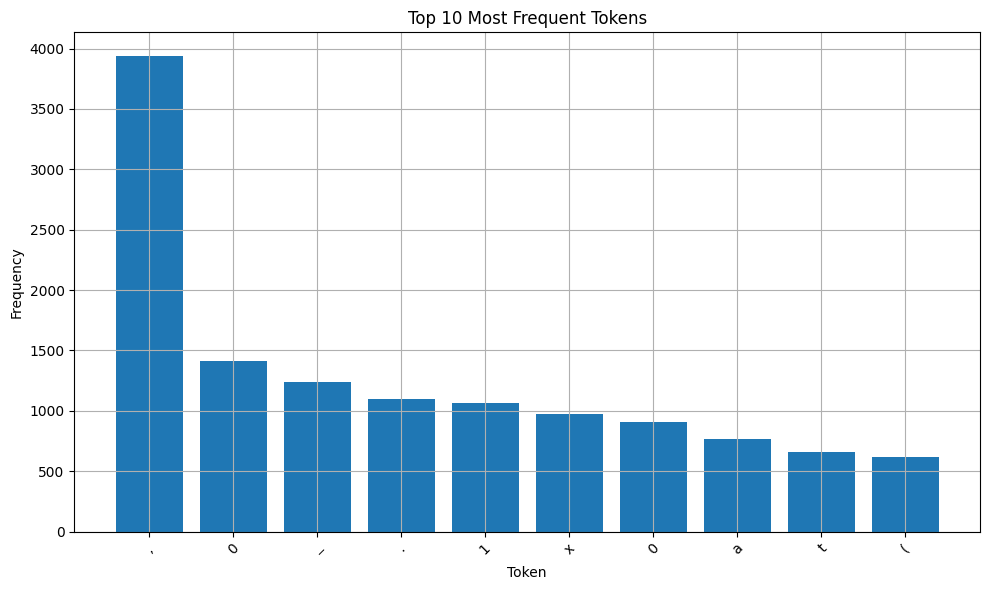

In [8]:
# Show top 10 most frequent tokens
plt.figure(figsize=(10,6))
top_tokens = [tokenizer.decode(token) for token in top_token_ids]
plt.bar(top_tokens, [token_counts[token] for token in top_token_ids])
plt.title("Top 10 Most Frequent Tokens")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Architecture:

In [9]:
def model_init():
    return AutoModelForCausalLM.from_pretrained("Salesforce/codegen-350M-multi")

# Shared data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training runner function
def run_training(version_name, training_args):
    print(f"\n🔁 Starting training: {version_name}")

    # Load fresh model
    model = model_init()

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        data_collator=data_collator,
    )

    # Train
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    perplexity = math.exp(eval_results["eval_loss"])

    print(f"✅ {version_name} Perplexity: {perplexity:.2f}")

    # Optional: Save model
    # trainer.save_model(training_args.output_dir)

    # Clean up
    del trainer
    del model
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    return eval_results, perplexity

## Training Configuration

In [14]:
# --- Version A ---
training_args_A = TrainingArguments(
    output_dir="./riscv_model_vA",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    learning_rate=5e-5,
    save_strategy="no",
    logging_steps=100,
    fp16=True,
    dataloader_num_workers=2,
)
eval_results_A, perplexity_A = run_training("Version A", training_args_A)


🔁 Starting training: Version A


Some weights of the model checkpoint at Salesforce/codegen-350M-multi were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (

Step,Training Loss
100,1.348100
200,0.726500
300,0.549500
400,0.442700


✅ Version A Perplexity: 2.56


In [11]:
# --- Version B ---
training_args_B = TrainingArguments(
    output_dir="./riscv_model_vB",
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    num_train_epochs=5,
    learning_rate=2.5e-5,
    save_strategy="no",
    logging_steps=50,
    fp16=True,
    dataloader_num_workers=4,
)
eval_results_B, perplexity_B = run_training("Version B", training_args_B)


🔁 Starting training: Version B


Some weights of the model checkpoint at Salesforce/codegen-350M-multi were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (

Step,Training Loss
50,1.700800
100,0.964300
150,0.774000
200,0.645600
250,0.584400
300,0.492600
350,0.486600
400,0.406800


✅ Version B Perplexity: 2.57


In [12]:
# --- Version C ---
training_args_C = TrainingArguments(
    output_dir="./riscv_model_vC",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    learning_rate=3e-5,
    save_strategy="no",
    logging_steps=100,
    fp16=True,
    dataloader_num_workers=2,
    weight_decay=0.01,
    warmup_steps=300,
)
eval_results_C, perplexity_C = run_training("Version C", training_args_C)


🔁 Starting training: Version C


Some weights of the model checkpoint at Salesforce/codegen-350M-multi were not used when initializing CodeGenForCausalLM: ['transformer.h.0.attn.causal_mask', 'transformer.h.1.attn.causal_mask', 'transformer.h.10.attn.causal_mask', 'transformer.h.11.attn.causal_mask', 'transformer.h.12.attn.causal_mask', 'transformer.h.13.attn.causal_mask', 'transformer.h.14.attn.causal_mask', 'transformer.h.15.attn.causal_mask', 'transformer.h.16.attn.causal_mask', 'transformer.h.17.attn.causal_mask', 'transformer.h.18.attn.causal_mask', 'transformer.h.19.attn.causal_mask', 'transformer.h.2.attn.causal_mask', 'transformer.h.3.attn.causal_mask', 'transformer.h.4.attn.causal_mask', 'transformer.h.5.attn.causal_mask', 'transformer.h.6.attn.causal_mask', 'transformer.h.7.attn.causal_mask', 'transformer.h.8.attn.causal_mask', 'transformer.h.9.attn.causal_mask']
- This IS expected if you are initializing CodeGenForCausalLM from the checkpoint of a model trained on another task or with another architecture (

Step,Training Loss
100,2.205800
200,0.910400
300,0.743400
400,0.613500


✅ Version C Perplexity: 2.49


In [15]:
import json
import os

# version = "C"  # or "B", or "C" — set manually per run

# Load previous results if the file exists
results_file = "training_results.json.json"
if os.path.exists(results_file):
    with open(results_file, "r") as f:
        all_results = json.load(f)
else:
    all_results = {}

# Add new result
all_results["A"] = {
    "eval_results": eval_results_A,
    "perplexity": perplexity_A
}
all_results["B"] = {
    "eval_results": eval_results_B,
    "perplexity": perplexity_B
}
all_results["C"] = {
    "eval_results": eval_results_C,
    "perplexity": perplexity_C
}


# Save updated results
with open(results_file, "w") as f:
    json.dump(all_results, f, indent=2)


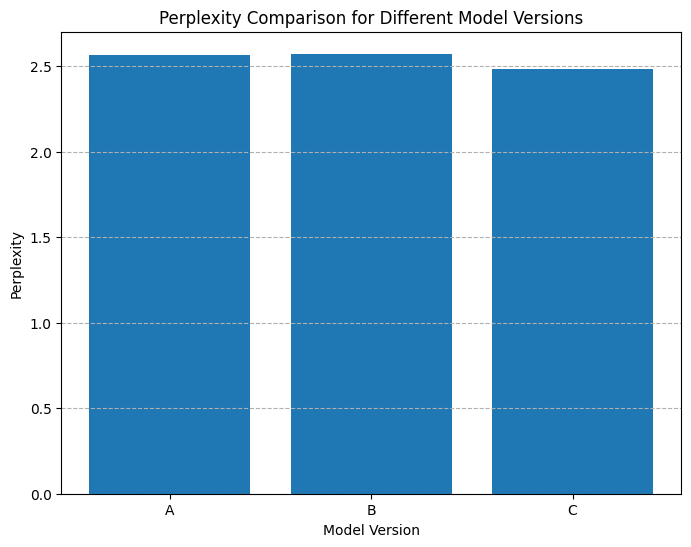

In [16]:
# prompt: plot perplexity

import matplotlib.pyplot as plt
import json

# Load results from the JSON file
with open("training_results.json.json", "r") as f:
    all_results = json.load(f)

# Extract perplexity values
versions = ["A", "B", "C"]
perplexities = [all_results[version]["perplexity"] for version in versions]

# Create the plot
plt.figure(figsize=(8, 6))
plt.bar(versions, perplexities)
plt.xlabel("Model Version")
plt.ylabel("Perplexity")
plt.title("Perplexity Comparison for Different Model Versions")
plt.grid(axis='y', linestyle='--')
plt.show()
